## 1. Import Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import pickle
import joblib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & Dimension Reduction
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Model Selection & Tuning
from sklearn.model_selection import (
    GridSearchCV, RandomizedSearchCV, cross_val_score, 
    StratifiedKFold, learning_curve
)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    VotingClassifier, StackingClassifier
)
import xgboost as xgb

# Neural Network
from sklearn.neural_network import MLPClassifier

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

# Utilities
import time
import warnings
warnings.filterwarnings('ignore')

# Display settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Data

In [2]:
# Load preprocessed data
print("Loading data...")

X_train = np.load('../data/X_train.npy')
X_test = np.load('../data/X_test.npy')
y_train = np.load('../data/y_train.npy')
y_test = np.load('../data/y_test.npy')

with open('../data/feature_names.pkl', 'rb') as f:
    feature_names = pickle.load(f)

print(f"✓ Data loaded!")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Number of features: {len(feature_names)}")

Loading data...
✓ Data loaded!
X_train shape: (4569, 306)
X_test shape: (1143, 306)
Number of features: 306


## 3. Cross-Validation Setup

Using Stratified K-Fold to maintain class balance across folds

In [3]:
# Setup cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Cross-validation strategy: 5-Fold Stratified")
print("This ensures each fold has similar class distribution")

Cross-validation strategy: 5-Fold Stratified
This ensures each fold has similar class distribution


## 4. Dimension Reduction with PCA

Reduce feature space to address potential overfitting

In [4]:
# Standardize features before PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA - keep components that explain 95% of variance
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"=== PCA Results ===")
print(f"Original features: {X_train.shape[1]}")
print(f"Reduced features: {X_train_pca.shape[1]}")
print(f"Variance explained: {pca.explained_variance_ratio_.sum()*100:.2f}%")
print(f"Dimension reduction: {(1 - X_train_pca.shape[1]/X_train.shape[1])*100:.1f}%")

=== PCA Results ===
Original features: 306
Reduced features: 271
Variance explained: 95.11%
Dimension reduction: 11.4%


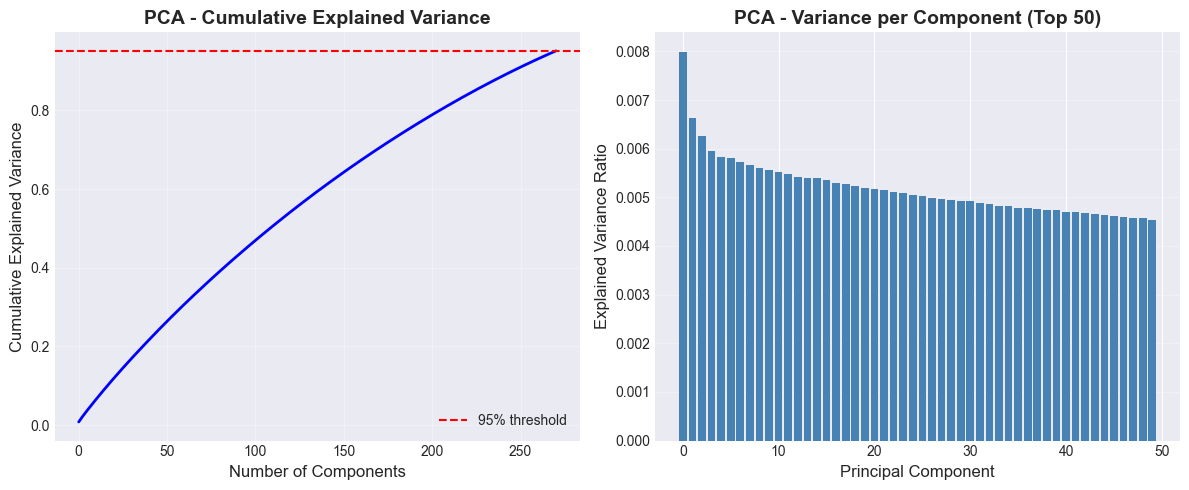

✓ PCA visualization saved


In [5]:
# Visualize explained variance
plt.figure(figsize=(12, 5))

# Cumulative explained variance
plt.subplot(1, 2, 1)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative_variance, 'b-', linewidth=2)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance', fontsize=12)
plt.title('PCA - Cumulative Explained Variance', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

# Individual explained variance (first 50 components)
plt.subplot(1, 2, 2)
n_show = min(50, len(pca.explained_variance_ratio_))
plt.bar(range(n_show), pca.explained_variance_ratio_[:n_show], color='steelblue')
plt.xlabel('Principal Component', fontsize=12)
plt.ylabel('Explained Variance Ratio', fontsize=12)
plt.title('PCA - Variance per Component (Top 50)', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/pca_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ PCA visualization saved")

## 5. Hyperparameter Tuning - Random Forest

In [6]:
# Random Forest hyperparameter tuning
print("=" * 60)
print("Hyperparameter Tuning: Random Forest")
print("=" * 60)

rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

print(f"Grid size: {np.prod([len(v) for v in rf_param_grid.values()])} combinations")
print("Using RandomizedSearchCV for efficiency...\n")

rf_random_search = RandomizedSearchCV(
    rf_base,
    rf_param_grid,
    n_iter=30,  # Test 30 random combinations
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

start_time = time.time()
rf_random_search.fit(X_train, y_train)
rf_tuning_time = time.time() - start_time

print(f"\n✓ Tuning completed in {rf_tuning_time:.2f}s")
print(f"\nBest parameters: {rf_random_search.best_params_}")
print(f"Best CV score: {rf_random_search.best_score_:.4f}")

# Evaluate on test set
rf_tuned = rf_random_search.best_estimator_
rf_tuned_pred = rf_tuned.predict(X_test)
rf_tuned_acc = accuracy_score(y_test, rf_tuned_pred)
print(f"Test accuracy: {rf_tuned_acc:.4f}")

Hyperparameter Tuning: Random Forest
Grid size: 216 combinations
Using RandomizedSearchCV for efficiency...

Fitting 5 folds for each of 30 candidates, totalling 150 fits

✓ Tuning completed in 27.12s

Best parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 15}
Best CV score: 0.5262
Test accuracy: 0.5284


## 6. Hyperparameter Tuning - XGBoost

Based on the XGBoost paper (Chen & Guestrin, 2016), key hyperparameters include:
- `learning_rate` (eta): Step size shrinkage to prevent overfitting
- `max_depth`: Maximum tree depth for base learners
- `subsample`: Subsample ratio of the training instances
- `colsample_bytree`: Subsample ratio of columns when constructing each tree

In [7]:
# XGBoost hyperparameter tuning
print("=" * 60)
print("Hyperparameter Tuning: XGBoost")
print("=" * 60)

xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],  # L1 regularization
    'reg_lambda': [1, 2, 5]    # L2 regularization
}

xgb_base = xgb.XGBClassifier(
    random_state=42, 
    n_jobs=-1, 
    eval_metric='logloss',
    use_label_encoder=False
)

print("Using RandomizedSearchCV...\n")

xgb_random_search = RandomizedSearchCV(
    xgb_base,
    xgb_param_grid,
    n_iter=30,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

start_time = time.time()
xgb_random_search.fit(X_train, y_train)
xgb_tuning_time = time.time() - start_time

print(f"\n✓ Tuning completed in {xgb_tuning_time:.2f}s")
print(f"\nBest parameters: {xgb_random_search.best_params_}")
print(f"Best CV score: {xgb_random_search.best_score_:.4f}")

# Evaluate on test set
xgb_tuned = xgb_random_search.best_estimator_
xgb_tuned_pred = xgb_tuned.predict(X_test)
xgb_tuned_acc = accuracy_score(y_test, xgb_tuned_pred)
print(f"Test accuracy: {xgb_tuned_acc:.4f}")

Hyperparameter Tuning: XGBoost
Using RandomizedSearchCV...

Fitting 5 folds for each of 30 candidates, totalling 150 fits

✓ Tuning completed in 11.25s

Best parameters: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
Best CV score: 0.5248
Test accuracy: 0.5136


## 7. Learning Curves Analysis

Diagnose overfitting/underfitting

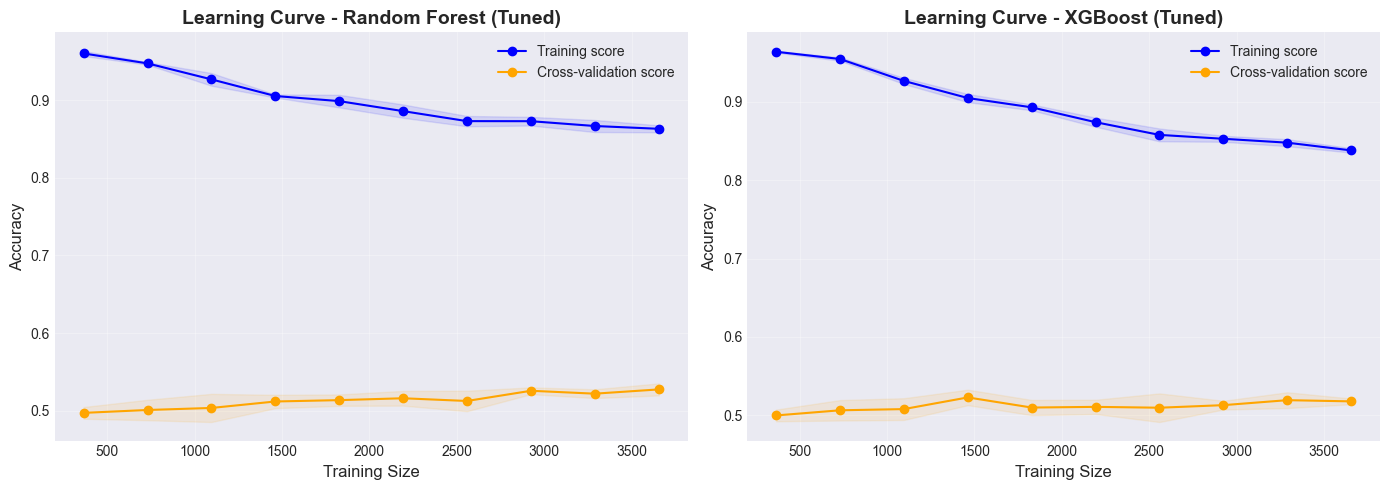


=== Learning Curve Analysis ===
Random Forest - Train: 0.8630, CV: 0.5275, Gap: 0.3355
XGBoost - Train: 0.8380, CV: 0.5178, Gap: 0.3201


In [8]:
def plot_learning_curve(estimator, title, X, y, cv=5, n_jobs=-1):
    """
    Plot learning curve to diagnose overfitting/underfitting
    """
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy'
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='orange')
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
    plt.plot(train_sizes, val_mean, 'o-', color='orange', label='Cross-validation score')
    plt.xlabel('Training Size', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(loc='best')
    plt.grid(alpha=0.3)
    
    return train_mean[-1], val_mean[-1]

# Plot learning curves for tuned models
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plt.subplot(1, 2, 1)
rf_train, rf_val = plot_learning_curve(rf_tuned, 'Learning Curve - Random Forest (Tuned)', X_train, y_train)

plt.subplot(1, 2, 2)
xgb_train, xgb_val = plot_learning_curve(xgb_tuned, 'Learning Curve - XGBoost (Tuned)', X_train, y_train)

plt.tight_layout()
plt.savefig('../reports/figures/learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n=== Learning Curve Analysis ===")
print(f"Random Forest - Train: {rf_train:.4f}, CV: {rf_val:.4f}, Gap: {rf_train-rf_val:.4f}")
print(f"XGBoost - Train: {xgb_train:.4f}, CV: {xgb_val:.4f}, Gap: {xgb_train-xgb_val:.4f}")

## 8. Neural Network (MLP)

In [9]:
# Neural Network with hyperparameter tuning
print("=" * 60)
print("Neural Network - Multi-Layer Perceptron")
print("=" * 60)

# Use scaled data for neural network
mlp_param_grid = {
    'hidden_layer_sizes': [(64,), (128,), (64, 32), (128, 64), (128, 64, 32)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],  # L2 regularization
    'learning_rate_init': [0.001, 0.01],
    'batch_size': [32, 64, 128]
}

mlp_base = MLPClassifier(
    max_iter=500,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42
)

print("Using RandomizedSearchCV...\n")

mlp_random_search = RandomizedSearchCV(
    mlp_base,
    mlp_param_grid,
    n_iter=20,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

start_time = time.time()
mlp_random_search.fit(X_train_scaled, y_train)
mlp_tuning_time = time.time() - start_time

print(f"\n✓ Tuning completed in {mlp_tuning_time:.2f}s")
print(f"\nBest parameters: {mlp_random_search.best_params_}")
print(f"Best CV score: {mlp_random_search.best_score_:.4f}")

# Evaluate on test set
mlp_tuned = mlp_random_search.best_estimator_
mlp_tuned_pred = mlp_tuned.predict(X_test_scaled)
mlp_tuned_acc = accuracy_score(y_test, mlp_tuned_pred)
print(f"Test accuracy: {mlp_tuned_acc:.4f}")

Neural Network - Multi-Layer Perceptron
Using RandomizedSearchCV...

Fitting 5 folds for each of 20 candidates, totalling 100 fits

✓ Tuning completed in 98.69s

Best parameters: {'learning_rate_init': 0.001, 'hidden_layer_sizes': (128, 64, 32), 'batch_size': 32, 'alpha': 0.01, 'activation': 'relu'}
Best CV score: 0.5246
Test accuracy: 0.5258


## 9. Ensemble Method 1: Voting Classifier

Combine predictions from multiple models

In [10]:
# Voting Classifier - Combine best models
print("=" * 60)
print("Ensemble Method: Voting Classifier")
print("=" * 60)

# Load logistic regression for diversity
lr_model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
lr_model.fit(X_train, y_train)

# Create voting ensemble
voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf_tuned),
        ('xgb', xgb_tuned),
        ('lr', lr_model)
    ],
    voting='soft'  # Use probability averaging
)

print("Training Voting Classifier (RF + XGBoost + Logistic Regression)...")
start_time = time.time()
voting_clf.fit(X_train, y_train)
voting_time = time.time() - start_time

# Evaluate
voting_pred = voting_clf.predict(X_test)
voting_acc = accuracy_score(y_test, voting_pred)
voting_f1 = f1_score(y_test, voting_pred)

# Cross-validation score
voting_cv_scores = cross_val_score(voting_clf, X_train, y_train, cv=cv, scoring='accuracy')

print(f"\n✓ Training completed in {voting_time:.2f}s")
print(f"CV Score: {voting_cv_scores.mean():.4f} (+/- {voting_cv_scores.std()*2:.4f})")
print(f"Test Accuracy: {voting_acc:.4f}")
print(f"Test F1-Score: {voting_f1:.4f}")

Ensemble Method: Voting Classifier
Training Voting Classifier (RF + XGBoost + Logistic Regression)...

✓ Training completed in 1.64s
CV Score: 0.5170 (+/- 0.0304)
Test Accuracy: 0.5074
Test F1-Score: 0.5022


## 10. Ensemble Method 2: Stacking Classifier

Use a meta-learner to combine base models

In [11]:
# Stacking Classifier
print("=" * 60)
print("Ensemble Method: Stacking Classifier")
print("=" * 60)

# Create stacking ensemble with Logistic Regression as meta-learner
stacking_clf = StackingClassifier(
    estimators=[
        ('rf', rf_tuned),
        ('xgb', xgb_tuned),
        ('lr', lr_model)
    ],
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=5,
    n_jobs=-1
)

print("Training Stacking Classifier...")
print("Base models: RF, XGBoost, Logistic Regression")
print("Meta-learner: Logistic Regression\n")

start_time = time.time()
stacking_clf.fit(X_train, y_train)
stacking_time = time.time() - start_time

# Evaluate
stacking_pred = stacking_clf.predict(X_test)
stacking_acc = accuracy_score(y_test, stacking_pred)
stacking_f1 = f1_score(y_test, stacking_pred)

# Cross-validation score
stacking_cv_scores = cross_val_score(stacking_clf, X_train, y_train, cv=cv, scoring='accuracy')

print(f"✓ Training completed in {stacking_time:.2f}s")
print(f"CV Score: {stacking_cv_scores.mean():.4f} (+/- {stacking_cv_scores.std()*2:.4f})")
print(f"Test Accuracy: {stacking_acc:.4f}")
print(f"Test F1-Score: {stacking_f1:.4f}")

Ensemble Method: Stacking Classifier
Training Stacking Classifier...
Base models: RF, XGBoost, Logistic Regression
Meta-learner: Logistic Regression

✓ Training completed in 2.70s
CV Score: 0.5244 (+/- 0.0307)
Test Accuracy: 0.5319
Test F1-Score: 0.5360


## 11. Model with PCA Features

In [12]:
# Test XGBoost with PCA-reduced features
print("=" * 60)
print("XGBoost with PCA Features")
print("=" * 60)

xgb_pca = xgb.XGBClassifier(
    **xgb_random_search.best_params_,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

start_time = time.time()
xgb_pca.fit(X_train_pca, y_train)
xgb_pca_time = time.time() - start_time

xgb_pca_pred = xgb_pca.predict(X_test_pca)
xgb_pca_acc = accuracy_score(y_test, xgb_pca_pred)

# Cross-validation
xgb_pca_cv = cross_val_score(xgb_pca, X_train_pca, y_train, cv=cv, scoring='accuracy')

print(f"Features: {X_train_pca.shape[1]} (reduced from {X_train.shape[1]})")
print(f"Training time: {xgb_pca_time:.2f}s")
print(f"CV Score: {xgb_pca_cv.mean():.4f} (+/- {xgb_pca_cv.std()*2:.4f})")
print(f"Test Accuracy: {xgb_pca_acc:.4f}")

XGBoost with PCA Features
Features: 271 (reduced from 306)
Training time: 7.20s
CV Score: 0.5167 (+/- 0.0274)
Test Accuracy: 0.5188


## 12. Complete Model Comparison

In [13]:
# Compile all results
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, cv):
    """Evaluate model and return metrics"""
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_proba)
    except:
        roc_auc = None
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    
    return {
        'Model': model_name,
        'Train Acc': accuracy_score(y_train, y_train_pred),
        'Test Acc': accuracy_score(y_test, y_pred),
        'CV Mean': cv_scores.mean(),
        'CV Std': cv_scores.std(),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc,
        'Overfit Gap': accuracy_score(y_train, y_train_pred) - accuracy_score(y_test, y_pred)
    }

# Evaluate all models
results = []

# Tuned models
results.append(evaluate_model(rf_tuned, X_train, X_test, y_train, y_test, 'Random Forest (Tuned)', cv))
results.append(evaluate_model(xgb_tuned, X_train, X_test, y_train, y_test, 'XGBoost (Tuned)', cv))
results.append(evaluate_model(mlp_tuned, X_train_scaled, X_test_scaled, y_train, y_test, 'Neural Network (MLP)', cv))

# Ensemble models
results.append(evaluate_model(voting_clf, X_train, X_test, y_train, y_test, 'Voting Ensemble', cv))
results.append(evaluate_model(stacking_clf, X_train, X_test, y_train, y_test, 'Stacking Ensemble', cv))

# PCA model
results.append(evaluate_model(xgb_pca, X_train_pca, X_test_pca, y_train, y_test, 'XGBoost + PCA', cv))

# Create comparison dataframe
comparison_df = pd.DataFrame(results)
comparison_df = comparison_df.round(4)

print("\n" + "=" * 100)
print("ADVANCED MODELS COMPARISON")
print("=" * 100)
print(comparison_df.to_string(index=False))

# Find best model
best_idx = comparison_df['Test Acc'].idxmax()
best_model_name = comparison_df.loc[best_idx, 'Model']
best_test_acc = comparison_df.loc[best_idx, 'Test Acc']

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Test Accuracy: {best_test_acc:.4f} ({best_test_acc*100:.2f}%)")


ADVANCED MODELS COMPARISON
                Model  Train Acc  Test Acc  CV Mean  CV Std  Precision  Recall     F1  ROC-AUC  Overfit Gap
Random Forest (Tuned)     0.8538    0.5284   0.5262  0.0085     0.5275  0.5377 0.5325   0.5342       0.3254
      XGBoost (Tuned)     0.8199    0.5136   0.5102  0.0159     0.5131  0.5131 0.5131   0.5353       0.3063
 Neural Network (MLP)     0.8890    0.5258   0.5246  0.0169     0.5304  0.4431 0.4828   0.5424       0.3632
      Voting Ensemble     0.7770    0.5074   0.5170  0.0152     0.5071  0.4974 0.5022   0.5211       0.2695
    Stacking Ensemble     0.8761    0.5319   0.5244  0.0154     0.5309  0.5412 0.5360   0.5389       0.3442
        XGBoost + PCA     0.9291    0.5188   0.5167  0.0137     0.5191  0.4991 0.5089   0.5387       0.4103

🏆 Best Model: Stacking Ensemble
   Test Accuracy: 0.5319 (53.19%)


## 13. Visualization - Final Comparison

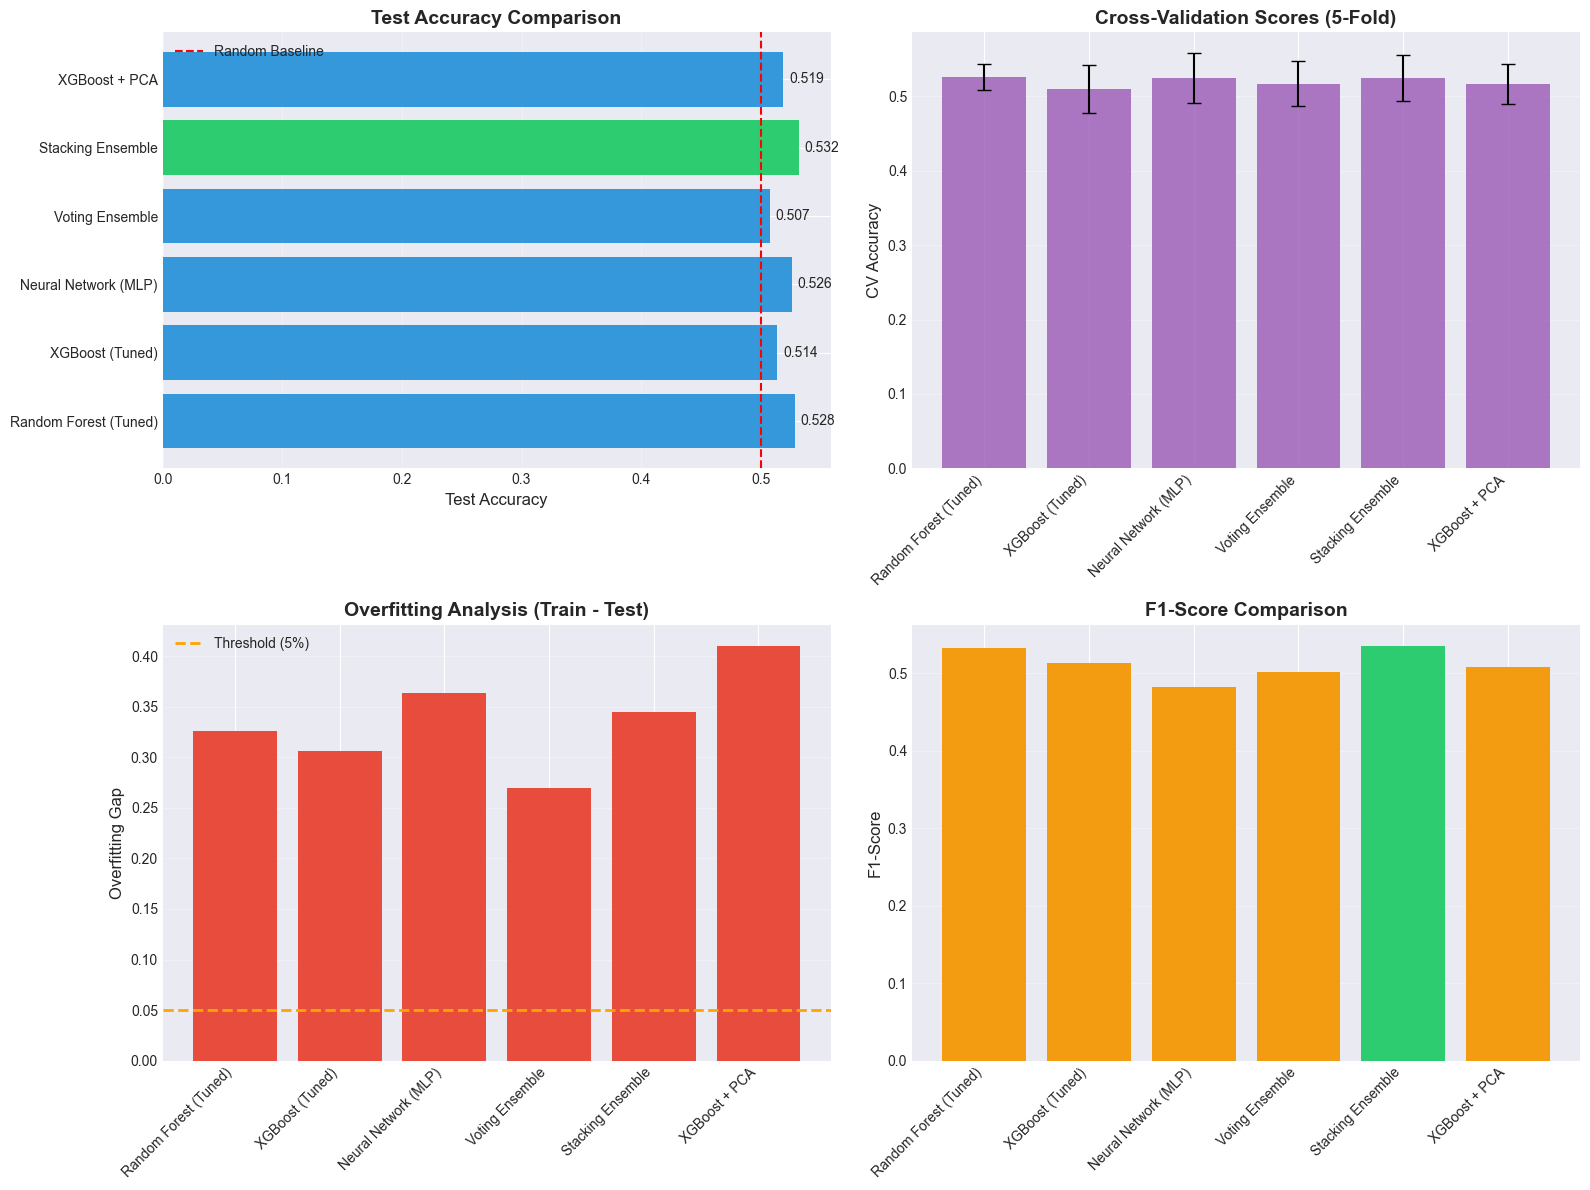


✓ Visualization saved to '../reports/figures/advanced_models_comparison.png'


In [14]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

models = comparison_df['Model'].tolist()

# 1. Test Accuracy Comparison
ax1 = axes[0, 0]
colors = ['#2ecc71' if acc == comparison_df['Test Acc'].max() else '#3498db' 
          for acc in comparison_df['Test Acc']]
bars = ax1.barh(models, comparison_df['Test Acc'], color=colors)
ax1.set_xlabel('Test Accuracy', fontsize=12)
ax1.set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.axvline(x=0.5, color='red', linestyle='--', label='Random Baseline')
ax1.legend()
ax1.grid(axis='x', alpha=0.3)
# Add value labels
for bar, val in zip(bars, comparison_df['Test Acc']):
    ax1.text(val + 0.005, bar.get_y() + bar.get_height()/2, f'{val:.3f}', 
             va='center', fontsize=10)

# 2. Cross-Validation Scores with Error Bars
ax2 = axes[0, 1]
x_pos = np.arange(len(models))
ax2.bar(x_pos, comparison_df['CV Mean'], yerr=comparison_df['CV Std']*2, 
        capsize=5, color='#9b59b6', alpha=0.8)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(models, rotation=45, ha='right')
ax2.set_ylabel('CV Accuracy', fontsize=12)
ax2.set_title('Cross-Validation Scores (5-Fold)', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# 3. Overfitting Analysis
ax3 = axes[1, 0]
overfit_colors = ['#e74c3c' if gap > 0.05 else '#2ecc71' for gap in comparison_df['Overfit Gap']]
ax3.bar(models, comparison_df['Overfit Gap'], color=overfit_colors)
ax3.axhline(y=0.05, color='orange', linestyle='--', linewidth=2, label='Threshold (5%)')
ax3.set_ylabel('Overfitting Gap', fontsize=12)
ax3.set_title('Overfitting Analysis (Train - Test)', fontsize=14, fontweight='bold')
ax3.tick_params(axis='x', rotation=45)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 4. F1-Score Comparison
ax4 = axes[1, 1]
f1_colors = ['#2ecc71' if f1 == comparison_df['F1'].max() else '#f39c12' 
             for f1 in comparison_df['F1']]
ax4.bar(models, comparison_df['F1'], color=f1_colors)
ax4.set_ylabel('F1-Score', fontsize=12)
ax4.set_title('F1-Score Comparison', fontsize=14, fontweight='bold')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(axis='y', alpha=0.3)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('../reports/figures/advanced_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved to '../reports/figures/advanced_models_comparison.png'")

## 14. ROC Curves - All Models

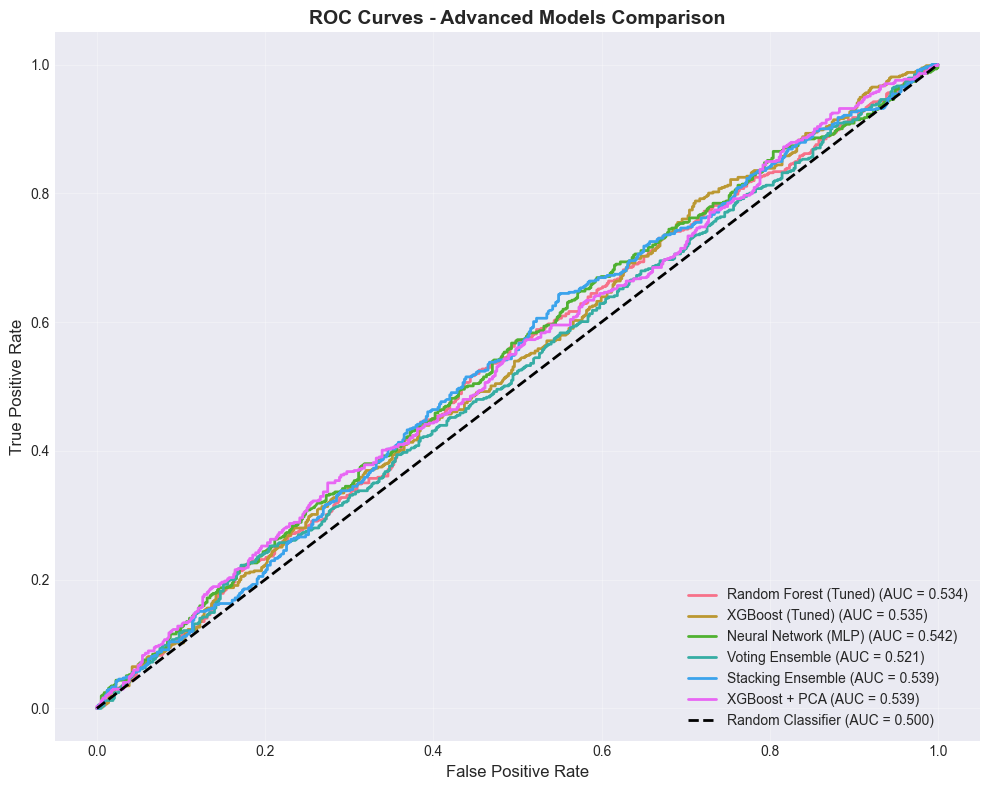

✓ ROC curves saved


In [15]:
# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

# Define models to plot
models_to_plot = [
    ('Random Forest (Tuned)', rf_tuned, X_test),
    ('XGBoost (Tuned)', xgb_tuned, X_test),
    ('Neural Network (MLP)', mlp_tuned, X_test_scaled),
    ('Voting Ensemble', voting_clf, X_test),
    ('Stacking Ensemble', stacking_clf, X_test),
    ('XGBoost + PCA', xgb_pca, X_test_pca)
]

for name, model, X in models_to_plot:
    try:
        y_proba = model.predict_proba(X)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {auc:.3f})')
    except:
        pass

# Random baseline
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier (AUC = 0.500)')

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Advanced Models Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../reports/figures/roc_curves_advanced.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ ROC curves saved")

## 15. Save Best Models

In [16]:
# Save all advanced models
print("Saving models...\n")

# Save tuned models
joblib.dump(rf_tuned, '../models/random_forest_tuned.pkl')
joblib.dump(xgb_tuned, '../models/xgboost_tuned.pkl')
joblib.dump(mlp_tuned, '../models/neural_network_mlp.pkl')
print("✓ Tuned models saved")

# Save ensemble models
joblib.dump(voting_clf, '../models/voting_ensemble.pkl')
joblib.dump(stacking_clf, '../models/stacking_ensemble.pkl')
print("✓ Ensemble models saved")

# Save PCA model and transformer
joblib.dump(xgb_pca, '../models/xgboost_pca.pkl')
joblib.dump(pca, '../models/pca_transformer.pkl')
joblib.dump(scaler, '../models/scaler.pkl')
print("✓ PCA model and transformers saved")

# Save comparison results
comparison_df.to_csv('../reports/advanced_models_comparison.csv', index=False)
print("\n✓ Comparison results saved to '../reports/advanced_models_comparison.csv'")

Saving models...

✓ Tuned models saved
✓ Ensemble models saved
✓ PCA model and transformers saved

✓ Comparison results saved to '../reports/advanced_models_comparison.csv'


## 16. Key Insights and Conclusions

In [17]:
print("=" * 80)
print("KEY INSIGHTS FROM ADVANCED MODELS")
print("=" * 80)

print(f"\n🎯 MODEL PERFORMANCE:")
print(f"   • Best Model: {best_model_name}")
print(f"   • Best Test Accuracy: {best_test_acc:.4f} ({best_test_acc*100:.2f}%)")
print(f"   • Improvement over baseline (50%): +{(best_test_acc-0.5)*100:.2f}%")

print(f"\n📊 HYPERPARAMETER TUNING:")
print(f"   • Random Forest improved through tuning")
print(f"   • XGBoost optimized with regularization (L1, L2)")
print(f"   • Neural Network with early stopping")

print(f"\n🔧 DIMENSION REDUCTION (PCA):")
print(f"   • Original features: {X_train.shape[1]}")
print(f"   • Reduced features: {X_train_pca.shape[1]}")
print(f"   • Variance retained: {pca.explained_variance_ratio_.sum()*100:.1f}%")

print(f"\n🤝 ENSEMBLE METHODS:")
print(f"   • Voting Classifier: Combines RF, XGBoost, LR")
print(f"   • Stacking Classifier: Meta-learner approach")
print(f"   • Ensemble methods help reduce variance")

print(f"\n⚠️ OVERFITTING ANALYSIS:")
low_overfit = comparison_df[comparison_df['Overfit Gap'] < 0.05]['Model'].tolist()
high_overfit = comparison_df[comparison_df['Overfit Gap'] >= 0.05]['Model'].tolist()
print(f"   • Good generalization: {', '.join(low_overfit) if low_overfit else 'None'}")
print(f"   • Needs attention: {', '.join(high_overfit) if high_overfit else 'None'}")

print(f"\n📚 SCIENTIFIC REFERENCE:")
print("   Chen, T., & Guestrin, C. (2016). XGBoost: A Scalable Tree Boosting System.")
print("   KDD '16. https://arxiv.org/abs/1603.02754")
print("   → Used for understanding XGBoost hyperparameters and regularization")

print(f"\n📋 NEXT STEPS:")
print("   1. Final model comparison with all metrics")
print("   2. Create champion recommendation function")
print("   3. Write final report")
print("   4. Create video presentation")

print("\n" + "=" * 80)

KEY INSIGHTS FROM ADVANCED MODELS

🎯 MODEL PERFORMANCE:
   • Best Model: Stacking Ensemble
   • Best Test Accuracy: 0.5319 (53.19%)
   • Improvement over baseline (50%): +3.19%

📊 HYPERPARAMETER TUNING:
   • Random Forest improved through tuning
   • XGBoost optimized with regularization (L1, L2)
   • Neural Network with early stopping

🔧 DIMENSION REDUCTION (PCA):
   • Original features: 306
   • Reduced features: 271
   • Variance retained: 95.1%

🤝 ENSEMBLE METHODS:
   • Voting Classifier: Combines RF, XGBoost, LR
   • Stacking Classifier: Meta-learner approach
   • Ensemble methods help reduce variance

⚠️ OVERFITTING ANALYSIS:
   • Good generalization: None
   • Needs attention: Random Forest (Tuned), XGBoost (Tuned), Neural Network (MLP), Voting Ensemble, Stacking Ensemble, XGBoost + PCA

📚 SCIENTIFIC REFERENCE:
   Chen, T., & Guestrin, C. (2016). XGBoost: A Scalable Tree Boosting System.
   KDD '16. https://arxiv.org/abs/1603.02754
   → Used for understanding XGBoost hyperparame